In [1]:
import csv
from collections import defaultdict
from collections import Counter
import datetime as dt
import dendropy
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from epiweeks import Week, Year
import tqdm
from scipy.stats import pearsonr
from scipy.stats import norm
import uncertainties.unumpy as unp
import seaborn as sns
import geopandas
import matplotlib.patches as mpatches

In [2]:
## get confidence interval

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(len(x)-3)
    z = norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi



## adm2 groups

In [3]:
lad_to_adm2 = {}
utla_to_adm2 = {}
with open("../Data/Lookup_Tables/LAD_UTLA_adm2.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        lad_to_adm2[l["LAD_name"].replace(" ","_")] = l["adm2"]
        utla_to_adm2[l["UTLA_name"].replace(" ","_")] = l['adm2']

## Sequence data

In [4]:
seq_metadata = #not available
full_metadata = #not available
de_anonymisation_key = #not available

In [5]:
tree = dendropy.Tree.get(path="new_run/best_tree_phylogeog.newick", schema='newick')

In [6]:
tips_in_tree = []
for tip in tree.leaf_iter():
    tips_in_tree.append(tip.taxon.label)
    
true_names = []
with open(de_anonymisation_key) as f:
    for l in f:
        toks = l.strip("\n").split(",")
        if toks[1] in tips_in_tree:
            true_names.append(toks[0].split("|")[0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'leaf_iter()' will no longer be supported in future releases; use 'leaf_node_iter()' instead
  


In [7]:
print(len(tips_in_tree))
print(len(true_names))

17716
17716


In [8]:
loc_to_adm2 = {}
dates = {}
with open(full_metadata) as f:
    data = csv.DictReader(f)
    for l in data:
        if l['sequence_name'] in true_names:
            loc_to_adm2[l['sequence_name']] = l['adm2']
            dates[l['sequence_name']] = l['sample_date']

In [9]:
agg_adm2_lookup = {}
with open(seq_metadata) as f:
    data = csv.DictReader(f)
    for l in data:
        if l['adm2'] in lad_to_adm2:
            agg_adm2_lookup[l['adm2']] = lad_to_adm2[l['adm2']]
        elif l['adm2'] in utla_to_adm2:
            agg_adm2_lookup[l['adm2']] = utla_to_adm2[l['adm2']]
        else:
            agg_adm2_lookup[l['adm2']] = l['aggregated_adm2']
      
        
    

In [10]:
#so the right sequence aggregated adm2
cleaned_aggs = {}
for k,v in loc_to_adm2.items():
    cleaned_aggs[k] = agg_adm2_lookup[v]

In [11]:
loc_to_dates = defaultdict(list)
loc_to_counter = {}
for k,v in cleaned_aggs.items():
    loc_to_dates[v].append(dates[k])
    
# for k,v in loc_to_seqs.items():
#     loc_to_counter[k] = len(v)

In [12]:
loc_to_weeks = defaultdict(list)
for loc, date_list in tqdm.tqdm(loc_to_dates.items()):
    for date in date_list:
        d = dt.datetime.strptime(date, "%Y-%m-%d").date()
        week = Week.fromdate(d)
        loc_to_weeks[loc].append(week)

100%|██████████| 59/59 [00:00<00:00, 160.13it/s]


In [13]:
location_week_counts = defaultdict(dict)
for location, week_list in loc_to_weeks.items():
    location_week_counts[location] = Counter(week_list)

## case data

In [14]:
cutoff = dt.date(2021,1,22)

In [38]:
raw_utla_to_case = defaultdict(dict)

with open("sgtf_utla_name.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        k = l['utla'].upper().replace(" ","_").replace(",","")
        case = float(l['cases'])
        date = dt.datetime.strptime(l['date'], "%Y-%m-%d").date()
        week = Week.fromdate(date)
        if date < cutoff:
            if week in raw_utla_to_case[k]:
                raw_utla_to_case[k][week] += case
            else:
                raw_utla_to_case[k][week] = case

In [43]:
proc_utla_to_case = defaultdict(dict)
for k,v in raw_utla_to_case.items():
    if k in lad_to_adm2:
        new_k = lad_to_adm2[k]
    elif k in utla_to_adm2:
        new_k = utla_to_adm2[k.replace(",","")]
    else:
        new_k = k.replace(",","")
        
    proc_utla_to_case[new_k] = v

## comparing number of sequences to number of sgtf cases

In [45]:
adm2_to_nuts = {}
with open("../Data/nuts_to_adm2.tsv") as f:
    for l in f:
        toks = l.strip("\n").split("\t")
        nuts = toks[0]
        adm2s = toks[1:]
        for i in adm2s:
            if i != "":
                adm2_to_nuts[i] = nuts

adm2_to_nuts["SOUTH_YORKSHIRE"] = "YORKSHIRE_AND_THE_HUMBER"
adm2_to_nuts["WEST_MIDLANDS"] = "WEST_MIDLANDS"
adm2_to_nuts["GREATER_MANCHESTER"] = "NORTH_WEST"
adm2_to_nuts["WEST_YORKSHIRE"] = "YORKSHIRE_AND_THE_HUMBER"
adm2_to_nuts["CHESHIRE"] = "NORTH_WEST"
adm2_to_nuts["MERSEYSIDE"] = "NORTH_WEST"
adm2_to_nuts["CORNWALL_AND_ISLES_OF_SCILLY"] = "SOUTH_WEST"

In [46]:
for utla in proc_utla_to_case.keys():
    if utla not in adm2_to_nuts:
        print(utla)

In [47]:
full_week_list = []
start_date = dt.date(2020,9,22)
end_date = cutoff

start_week = Week.fromdate(start_date)
end_week = Week.fromdate(end_date)

wk_20 = Year(2020).iterweeks()
wk_21 = Year(2021).iterweeks()

full_week_list.append(start_week)

for week in wk_20:
    if week > start_week:
        full_week_list.append(week)
for week in wk_21:
    if week < end_week:
        full_week_list.append(week)
        
full_week_list.append(end_week)



In [48]:
for k in loc_to_counter:
    if k not in proc_utla_to_case:
        print(k, loc_to_counter[k])
        
#so these are ones that we can't compare directly to cases because we don't know exactly what utla they fall in

In [49]:
x = []
y = []
for location in proc_utla_to_case.keys():
    week_list_seqs = location_week_counts[location]
    week_list_cases = proc_utla_to_case[location]
    
    for week in full_week_list:
        if week in week_list_seqs and week in week_list_cases:
            x.append(np.log10(week_list_cases[week]))
            y.append(np.log10(week_list_seqs[week]))
        elif week not in week_list_seqs and week not in week_list_cases:
            x.append(0)
            y.append(0)
       

0.5290593679673694 -0.005391757468157109
0.6855087403392887 3.1114616103852897e-57


/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


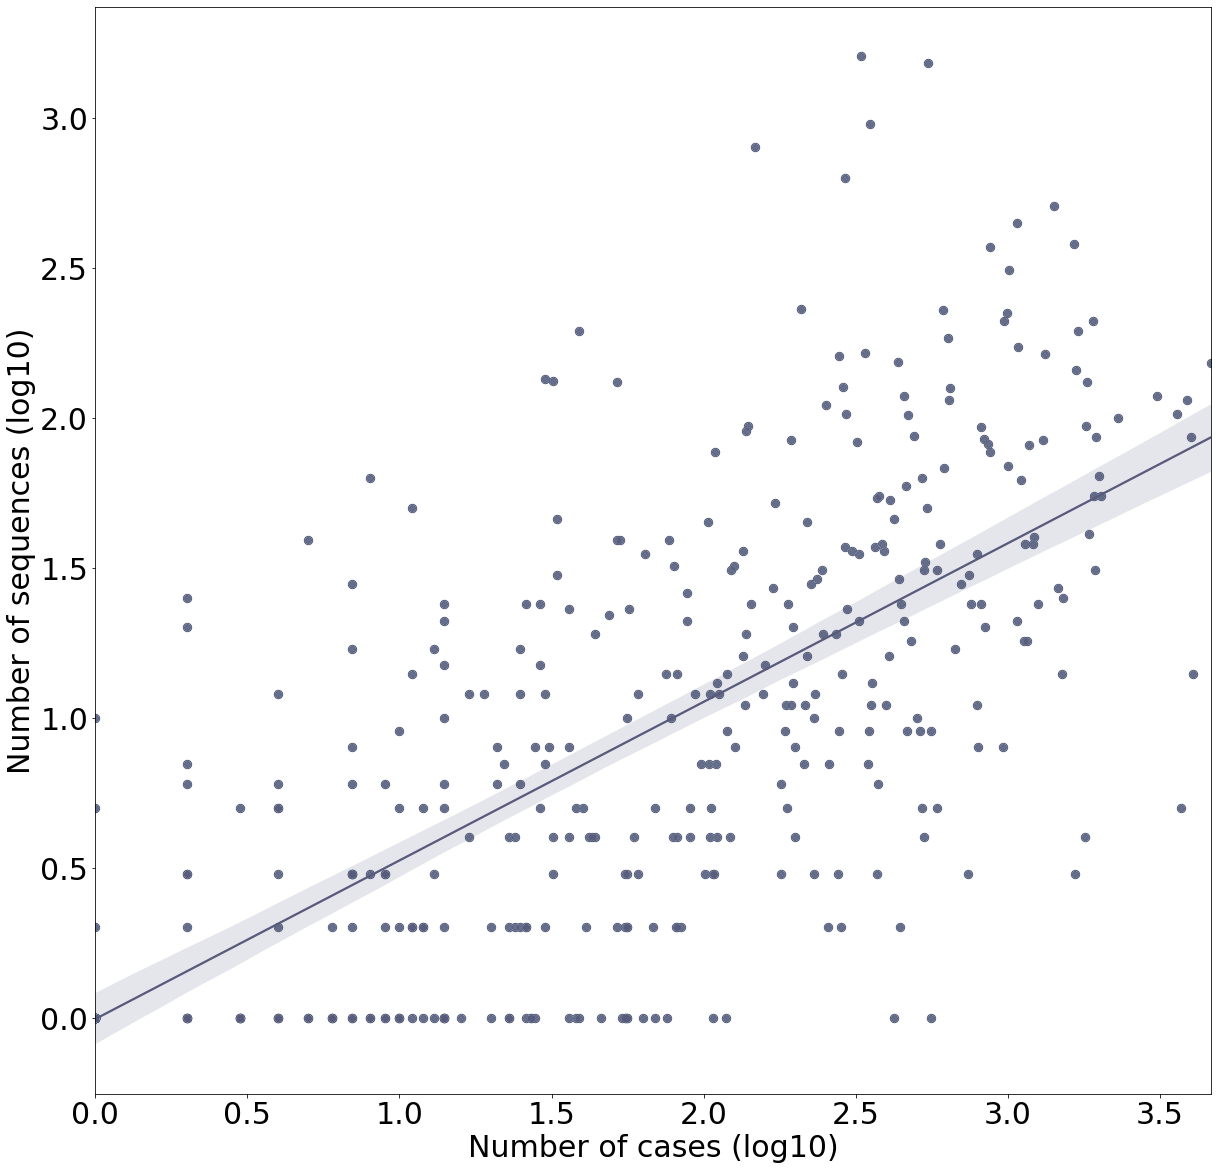

(0.6855087403392887,
 3.1114616103852897e-57,
 0.6300113831111576,
 0.7340398917592363)

In [54]:
plt.rcParams.update({'font.size': 30})

m,c = np.polyfit(x, y, 1)
ys = []
for ele in x:
    ys.append((ele*m) + c)
print(m,c)
corr,p = pearsonr(x,y)
print(corr,p)

nom = unp.nominal_values(ys)
std = unp.std_devs(ys)

fig, ax = plt.subplots(1,1, figsize=(20,20))

ax.scatter(x,y, s=70, color="#575A7A")
ax.scatter(x,y, s=40, color="#A3C5CF")
# ax.scatter(x,y, s=40, color="fuchsia")

# ax.plot(x,ys, linewidth=5, color="#575A7A")
sns.regplot(x,y, color="#575A7A")

ax.set_xlabel("Number of cases (log10)")
ax.set_ylabel("Number of sequences (log10)")

plt.savefig("sequence_case_correlation.pdf")
plt.savefig("sequence_case_correlation.svg")

plt.show()

pearsonr_ci(x,y)

## colouring above figure to check where the outliers are from

In [51]:
cmap = cm.get_cmap("Paired")
colors = cmap(np.linspace(0, 1,9))
nut_set = set()
for nuts in adm2_to_nuts.values():
    if nuts != "SCOTLAND" and nuts != "NORTHERN_IRELAND" and nuts != "CHANNEL_ISLANDS" and nuts != "WALES":
        nut_set.add(nuts)
        
colour_dict = {}
for i,j in zip(nut_set, colors):
    colour_dict[i] = j
    


In [52]:
x = []
y = []
annotations = []
for location in proc_utla_to_case.keys():
    nuts = adm2_to_nuts[location]
    week_list_seqs = location_week_counts[location]
    week_list_cases = proc_utla_to_case[location]
    
    for week in full_week_list:
        if week in week_list_seqs and week in week_list_cases:
            x.append(np.log10(week_list_cases[week]))
            y.append(np.log10(week_list_seqs[week]))
            annotations.append(colour_dict[nuts])
        elif week not in week_list_seqs and week not in week_list_cases:
            x.append(0)
            y.append(0)
            annotations.append(colour_dict[nuts])
        



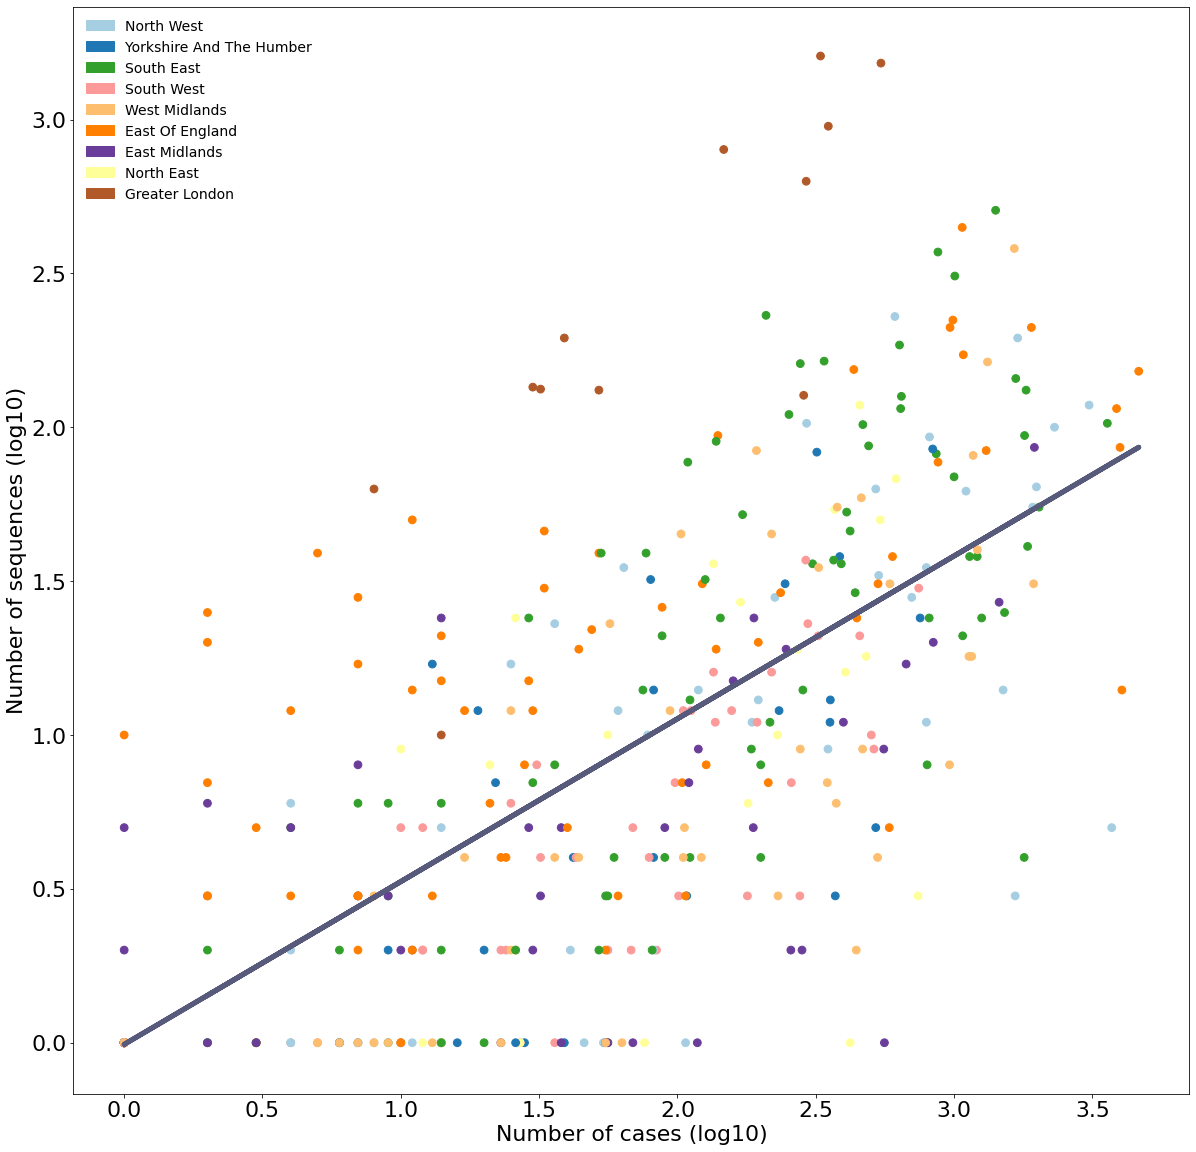

(0.6855087403392887,
 3.1114616103852897e-57,
 0.6300113831111576,
 0.7340398917592363)

In [53]:
plt.rcParams.update({'font.size': 22})

m,c = np.polyfit(x, y, 1)
ys = []
for ele in x:
    ys.append((ele*m) + c)
corr,p = pearsonr(x,y)


nom = unp.nominal_values(ys)
std = unp.std_devs(ys)

fig, ax = plt.subplots(1,1, figsize=(20,20))

# ax.scatter(x,y, s=70, color="#575A7A")
# ax.scatter(x,y, s=40, color="#A3C5CF")
ax.scatter(x,y, s=60, color=annotations)

ax.plot(x,ys, linewidth=5, color="#575A7A")
# sns.regplot(x,y, color="#575A7A")

ax.set_xlabel("Number of cases (log10)")
ax.set_ylabel("Number of sequences (log10)")

patch_list = []
for nuts, colour in colour_dict.items():
    patch_list.append(mpatches.Patch(color=colour, label=nuts.title().replace("_"," ")))
ax.legend(handles=patch_list, loc="upper left",fontsize=14,frameon=False)


# plt.savefig("../B117_UK/Figures/sequence_case_correlation.pdf")

plt.show()

pearsonr_ci(x,y)

## Imports vs cases

In [55]:
utla_df = geopandas.read_file("../Data/UTLA_administrative_areas.json")
utla_df

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
0,Cheshire East (B),UTA,Unitary Authority,CHESHIRE_EAST_(B),1,1,123504,43553,E06000049,116635.738,0.000,AA,CIVIL ADMINISTRATION AREA,,,"POLYGON ((-2.03106 53.37025, -2.03102 53.37032..."
1,Central Bedfordshire,UTA,Unitary Authority,CENTRAL_BEDFORDSHIRE,2,2,123600,43870,E06000056,71566.530,0.000,AA,CIVIL ADMINISTRATION AREA,,,"POLYGON ((-0.35486 51.87401, -0.35528 51.87389..."
2,Casnewydd - Newport,UTA,Unitary Authority,CASNEWYDD_-_NEWPORT,3,3,71446,44426,W06000022,21751.796,2708.683,AA,CIVIL ADMINISTRATION AREA,,,"POLYGON ((-3.11888 51.54564, -3.11890 51.54552..."
3,Castell-nedd Port Talbot - Neath Port Talbot,UTA,Unitary Authority,CASTELL-NEDD_PORT_TALBOT_-_NEATH_PORT_TALBOT,4,4,71445,25498,W06000012,45187.536,960.274,AA,CIVIL ADMINISTRATION AREA,,,"POLYGON ((-3.93649 51.77135, -3.93632 51.77133..."
4,Bracknell Forest (B),UTA,Unitary Authority,BRACKNELL_FOREST_(B),5,5,101679,38893,E06000036,10938.421,0.000,AA,CIVIL ADMINISTRATION AREA,,,"POLYGON ((-0.77548 51.33196, -0.77522 51.33194..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,Barking and Dagenham London Boro,LBO,London Borough,GREATER_LONDON_AUTHORITY,364,364,51295,10949,E09000002,3778.184,168.045,AA,CIVIL ADMINISTRATION AREA,,,"POLYGON ((0.15787 51.50877, 0.15787 51.50884, ..."
364,City and County of the City of London,LBO,London Borough,GREATER_LONDON_AUTHORITY,365,365,51187,11105,E09000001,314.688,25.720,AA,CIVIL ADMINISTRATION AREA,,,"POLYGON ((-0.08526 51.52035, -0.08534 51.52020..."
365,North Norfolk District,DIS,District,NORFOLK_COUNTY,366,366,47877,7024,E07000147,98999.104,2243.780,AA,CIVIL ADMINISTRATION AREA,,,"MULTIPOLYGON (((1.67513 52.74262, 1.67513 52.7..."
366,South Hams District,DIS,District,DEVON_COUNTY,367,367,122080,22569,E07000044,90520.643,1866.282,AA,CIVIL ADMINISTRATION AREA,,,"MULTIPOLYGON (((-3.58423 50.47774, -3.58440 50..."


In [56]:
boro_dict = {}
for num, boro, county in zip(utla_df.index,utla_df["NAME"],utla_df["FILE_NAME"]):
    if county == "GREATER_LONDON_AUTHORITY":
        boro_dict[num+1] = boro

In [57]:
num_to_name = {}
for i, j in zip(utla_df.index, utla_df["FILE_NAME"]):
    name = j.upper().replace(" ","_").replace("_(B)","").replace("_COUNTY","").replace("THE_CITY_OF_","").replace("CITY_OF_","").replace("_DISTRICT","").replace("COUNTY_OF_","")
    
    if j == "GREATER_LONDON_AUTHORITY":
#         print(i,j)
        name = boro_dict[i+1].replace(" ","_").upper().replace("_BORO","").replace("_LONDON","").replace("CITY_OF_","")
        if name == "CITY_AND_COUNTY_OF_THE_CITY_OF":
            name = "CITY_OF_LONDON"
    
    num_to_name[i+1] = name
    
    

In [81]:
def make_import_case_correlation(cutoff_early, cutoff_late, file_name):
        
    name_to_intros = defaultdict(dict)
    
    with open("transition_intro_data/UTLA_introductions.csv") as f:
        data = csv.DictReader(f)
        headers = data.fieldnames
        for l in data:
            k = num_to_name[int(l["location"])]
            for date in headers:
                if date != "location":
                    case = int(l[date])
                    date_obj = dt.datetime.strptime(date, "%Y-%m-%d").date()
                    week = Week.fromdate(date_obj)
                    if date_obj <= cutoff_late and date_obj >= cutoff_early:
                        if week in name_to_intros[k]:
                            name_to_intros[k][week] += case
                        else:
                            name_to_intros[k][week] = case
                            
    name_to_case = defaultdict(dict)

    with open("sgtf_utla_name.csv") as f:
        data = csv.DictReader(f)
        for l in data:
            k = l['utla'].upper().replace(" ","_").replace(",_CITY_OF","").replace(",_COUNTY_OF","")
            case = float(l['cases'])
            date = dt.datetime.strptime(l['date'], "%Y-%m-%d").date()
            week = Week.fromdate(date)
            if date <= cutoff_late and date >= cutoff_early:
                if week in name_to_case[k]:
                    name_to_case[k][week] += case
                else:
                    name_to_case[k][week] = case
                    
    x = []
    y = []
    for location in name_to_case.keys():
        week_list_intros = name_to_intros[location]
        week_list_cases = name_to_case[location]

        for week in full_week_list:
            if week in week_list_intros and week in week_list_cases:
                x.append(np.log10(week_list_cases[week]+1))
                y.append(np.log10(week_list_intros[week]+1))
            elif week not in week_list_intros and week not in week_list_cases:
                x.append(0)
                y.append(0)
                                
    plt.rcParams.update({'font.size': 40})

#     m,c = np.polyfit(x, y, 1)
#     ys = []
#     for ele in x:
#         ys.append((ele*m) + c)
#     corr,p = pearsonr(x,y)

#     nom = unp.nominal_values(ys)
#     std = unp.std_devs(ys)

    fig, ax = plt.subplots(1,1, figsize=(20,20))

    ax.scatter(x,y, s=70, color="#575A7A")
    ax.scatter(x,y, s=40, color="#A3C5CF")
    # ax.scatter(x,y, s=40, color="fuchsia")

    # ax.plot(x,ys, linewidth=5, color="#575A7A")
    sns.regplot(x,y, color="#575A7A")

    ax.set_xlabel("Number of cases (log10)")
    ax.set_ylabel("Number of introductions (log10)")

    plt.savefig(f"../B117_UK/Figures/{file_name}.pdf")
    plt.savefig(f"../B117_UK/Figures/{file_name}.svg")


    
    pearson = pearsonr_ci(x,y)
    
    return pearson

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/site-package

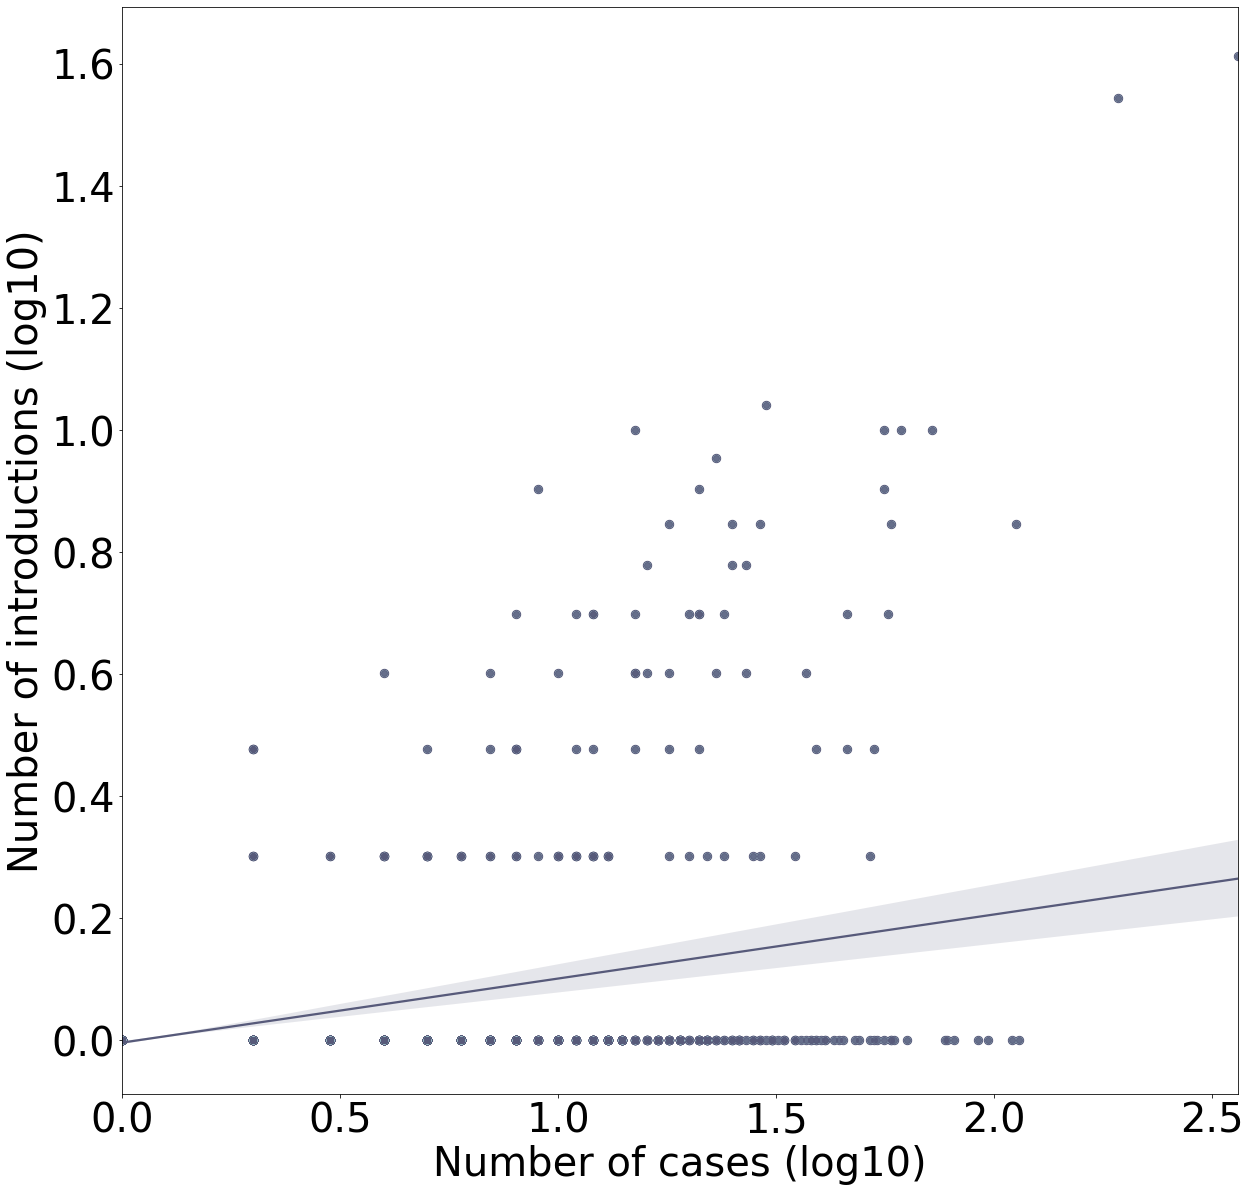

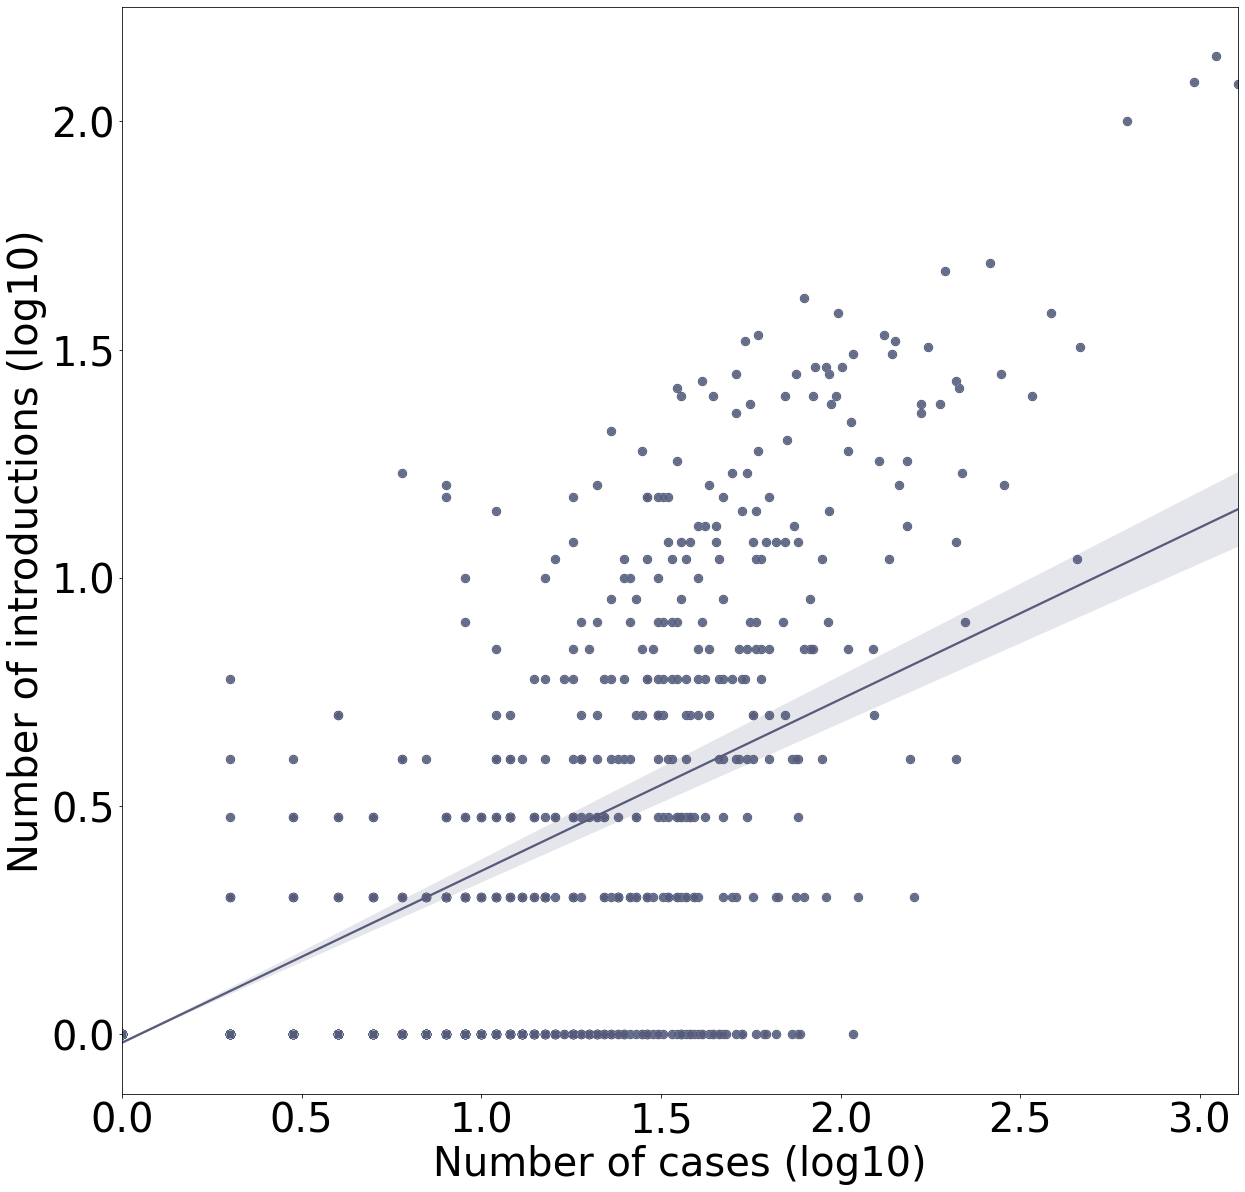

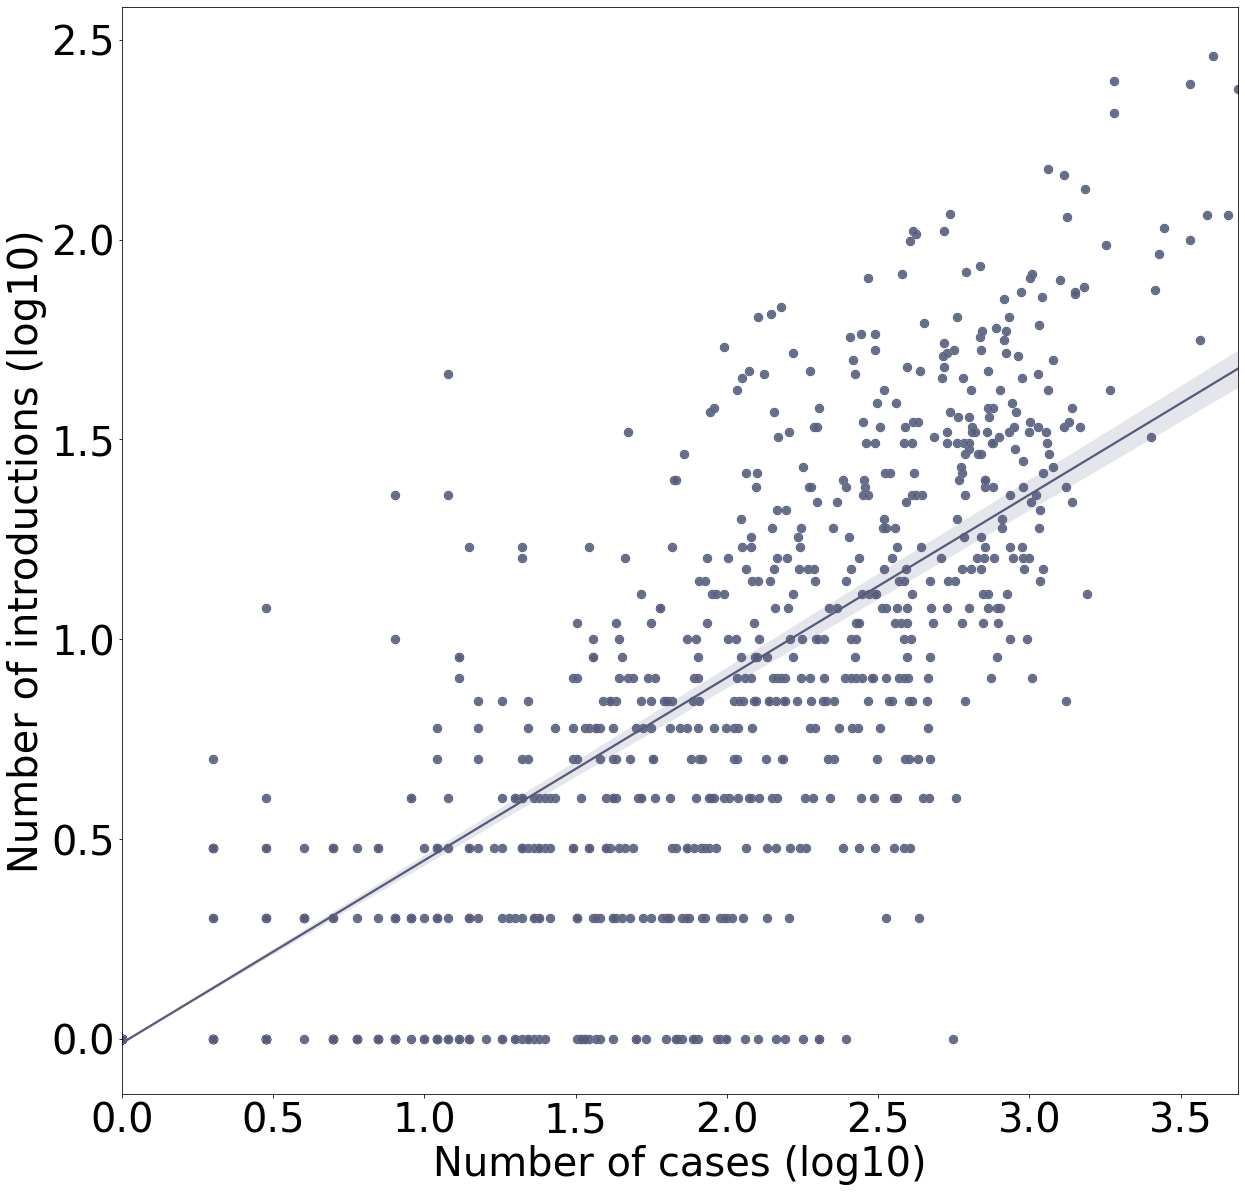

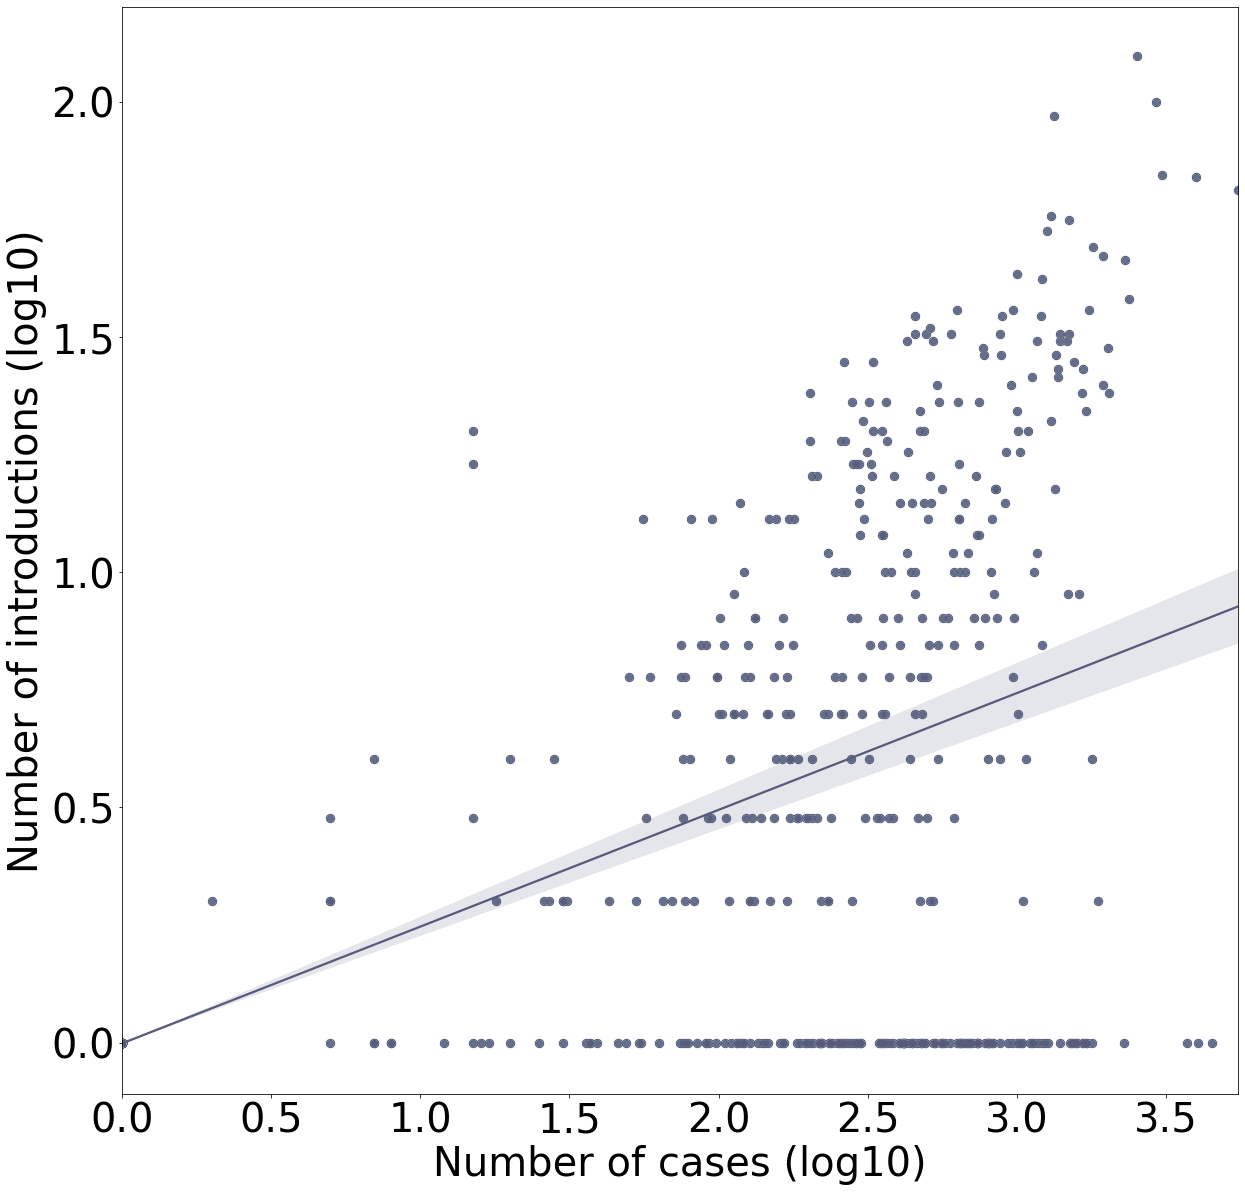

In [82]:
oct_pearson = make_import_case_correlation(dt.date(2020,10,1), dt.date(2020,10,31), "import_case_corr_oct")
nov_pearson = make_import_case_correlation(dt.date(2020,11,1), dt.date(2020,11,30), "import_case_corr_nov")
dec_pearson = make_import_case_correlation(dt.date(2020,12,1), dt.date(2020,12,31), "import_case_corr_dec")
jan_pearson = make_import_case_correlation(dt.date(2021,1,1), dt.date(2021,1,31), "import_case_corr_jan")

In [498]:
print(oct_pearson)
print(nov_pearson)
print(dec_pearson)
print(jan_pearson)

(0.4093137736480683, 1.2454705429032751e-105, 0.3768076258699583, 0.440813018816617)
(0.758124023752141, 0.0, 0.7414957834455017, 0.7738215717541667)
(0.9109610284581312, 0.0, 0.9042974810681543, 0.9171807865616824)
(0.7305919677817149, 0.0, 0.7119661766418157, 0.7481904755947859)


/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


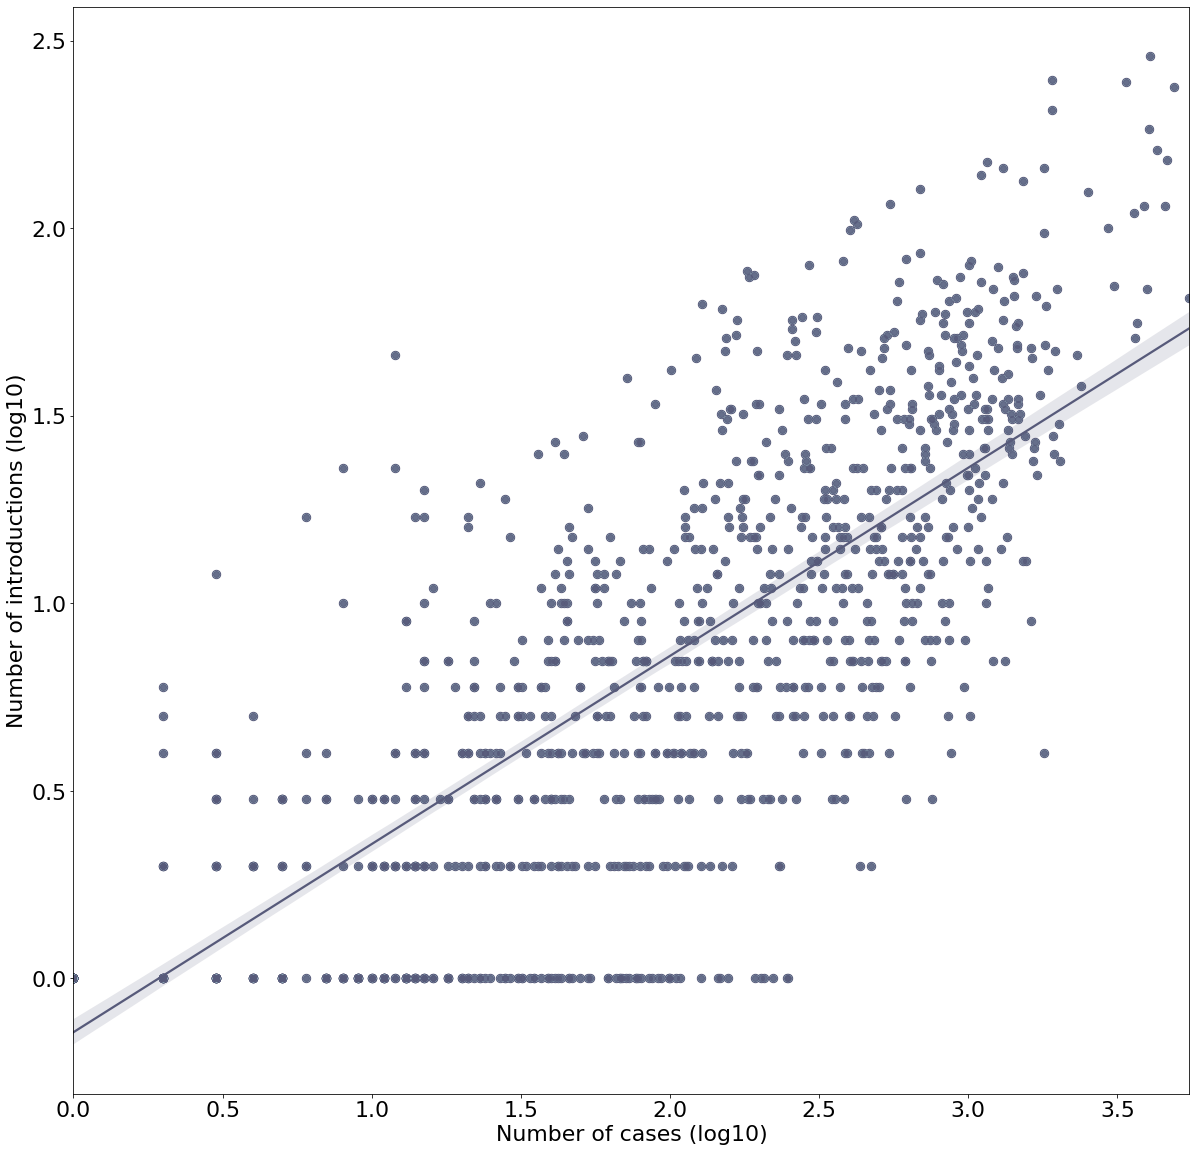

In [481]:
overall_pearson = make_import_case_correlation(dt.date(2020,1,1), dt.date(2021,12,31), "import_case_corr_overall")

In [483]:
print(overall_pearson)

(0.7939234178750193, 3.4887084593214478e-251, 0.7715656964088345, 0.814322254081992)


In [479]:
utla_set = set()
with open("../B117_UK/Data/Lookup_Tables/LAD_UTLA_adm2.csv") as f:
    next(f)
    for l in f:
        utla_set.add(l.strip("\n").split(",")[2])
        
print(len(utla_set))

155


In [480]:
print(utla_set)

{'E10000012', 'S12000017', 'E06000002', 'E06000036', 'E10000024', 'W06000013', 'S12000050', 'E11000005', 'E06000047', 'E06000044', 'E10000016', 'E06000045', 'W06000016', 'W06000022', 'E06000006', 'E06000049', 'W06000014', 'E10000025', 'E06000034', 'E06000046', 'E06000040', 'E06000019', 'E06000058', 'S12000048', 'S12000027', 'S12000040', 'E10000002', 'E06000018', 'S12000019', 'S12000042', 'W06000015', 'E06000012', 'W06000011', 'W06000008', 'E06000021', 'E10000011', 'E10000018', 'N09000001', 'N09000002', 'N09000009', 'E10000031', 'E06000009', 'E10000032', 'E06000052', 'E10000008', 'E10000029', 'S12000010', 'S12000011', 'S12000020', 'E06000013', 'N09000011', 'E06000015', 'S12000028', 'N09000008', 'E10000021', 'E10000006', 'E06000008', 'E11000003', 'E06000026', 'E06000007', 'E06000039', 'S12000029', 'S12000034', 'E06000041', 'S12000045', 'E06000035', 'E10000017', 'E06000043', 'E06000017', 'S12000026', 'E11000002', 'S12000039', 'S12000041', 'W06000018', 'S12000018', 'N09000007', 'E06000003'